# Buy & Sell Trades and calculate PNL

In [16]:
import pandas as pd
import numpy as np

# Load data from CSV with absolute path
csv_path = 'signals_4h_supertrend.csv'
df = pd.read_csv(csv_path, parse_dates=['timestamp'], index_col='timestamp')

# Sample data creation using loaded CSV data
sample_data = {
    'timestamp': df.index,
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'close': df['close'],
    'Super_Trend_signal' : df ['Super_Trend_signal'],
    'Signals':df ['Signals'],
    'volumn':df['volume'],
    'Super_Trend' : df['Super_Trend']
}

# Create DataFrame from sample data
sample_df = pd.DataFrame(sample_data)
sample_df.reset_index(drop=True, inplace=True)
sample_df.set_index('timestamp', inplace=True)

# Function to generate signals and calculate PnL (updated version)
def generate_signals(df):
    # Initialize the necessary lists
    action = []
    buy_price = []
    sell_price = []
    pnl = []
    date_time = []
    signal = []

    # Loop through the dataframe to generate the ledger
    for i in range(1, len(df)):
        if len(action) == 0:
            action.append(df['Super_Trend_signal'].iloc[i])
            buy_price.append(df['open'].iloc[i])
            date_time.append(df.index[i])
            sell_price.append(np.nan)
            pnl.append(np.nan)
            signal.append(df['Super_Trend_signal'].iloc[i])
        else:
            if action[-1] == df['Super_Trend_signal'].iloc[i] or df['Super_Trend_signal'].iloc[i] == 0:
                continue
            else:
                action.append(df['Super_Trend_signal'].iloc[i])
                sell_price.append(df['close'].iloc[i])
                date_time.append(df.index[i])
                buy_price.append(np.nan)
                signal.append(df['Super_Trend_signal'].iloc[i])
                pnl.append(np.nan)

                action.append(df['Super_Trend_signal'].iloc[i])
                buy_price.append(df['close'].iloc[i])
                date_time.append(df.index[i])
                sell_price.append(np.nan)
                signal.append(df['Super_Trend_signal'].iloc[i])
                pnl.append(np.nan)

    # Create the ledger dataframe
    ledger = pd.DataFrame({
        'date_time': date_time, 
        'signal': signal, 
        'action': action, 
        'buy_price': buy_price, 
        'sell_price': sell_price, 
        'pnl': pnl
    })
    ledger['action'] = ledger['action'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger['buy_price'] = ledger['buy_price'].fillna(method='ffill')
    ledger['signal'] = ledger['signal'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger['action'] = ledger['action'].replace({'Buy': 'Long', 'Sell': 'Short'})

    # Function to calculate PnL and balance
    def calculate_pnl_and_balance(df):
        balance = 10000  # Starting balance
        balances = []  # List to store balance after each transaction

        for index, row in df.iterrows():
            buy_price = float(row['buy_price'])
            sell_price = float(row['sell_price'])

            if pd.isna(sell_price) or pd.isna(buy_price):
                balances.append(balance)  # No change in balance
                continue

            if df.iloc[index-1]['signal'] == 'Buy':  # Long
                pnl_percent = ((sell_price - buy_price) / buy_price) * 100
            elif df.iloc[index-1]['signal'] == 'Sell':  # Short
                pnl_percent = ((buy_price - sell_price) / buy_price) * 100
            else:
                pnl_percent = 0

            pnl_change = balance * (pnl_percent / 100)  # Calculate change in balance
            balance += pnl_change  # Update balance
            balances.append(balance)  # Store updated balance

            df.at[index, 'pnl'] = round(pnl_percent, 2)  # Efficient assignment

        df['balance'] = balances  # Add balance column to DataFrame
        return df

    # Calculate PnL and balance
    ledger_with_pnl = calculate_pnl_and_balance(ledger.copy())  # Use a copy to avoid modifying the original dataframe
    ledger_with_pnl['date_time'] = pd.to_datetime(ledger_with_pnl['date_time'])
    ledger_with_pnl['pnl'] = ledger_with_pnl['pnl'].fillna(0)
    ledger_with_pnl['sell_price'].fillna(0, inplace=True)

    return ledger_with_pnl

# Generate signals and calculate PnL
processed_ledger = generate_signals(sample_df)

# Display the resulting ledger DataFrame
print(processed_ledger)



C:\Users\MTariq\AppData\Local\Temp\ipykernel_10972\3845842728.py:73: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger['buy_price'] = ledger['buy_price'].fillna(method='ffill')


               date_time signal action  buy_price  sell_price  pnl  balance
0    2020-01-01 04:00:00   Sell  Short    7225.00        0.00  0.0  10000.0
1    2020-01-01 08:00:00    Buy   Long    7225.00     7197.20  0.0  10000.0
2    2020-01-01 08:00:00    Buy   Long    7197.20        0.00  0.0  10000.0
3    2020-01-01 12:00:00   Sell  Short    7197.20     7234.19  0.0  10000.0
4    2020-01-01 12:00:00   Sell  Short    7234.19        0.00  0.0  10000.0
...                  ...    ...    ...        ...         ...  ...      ...
8892 2024-08-11 12:00:00   Sell  Short   60040.01        0.00  0.0  10000.0
8893 2024-08-11 16:00:00    Buy   Long   60040.01    59662.02  0.0  10000.0
8894 2024-08-11 16:00:00    Buy   Long   59662.02        0.00  0.0  10000.0
8895 2024-08-11 20:00:00   Sell  Short   59662.02    58711.99  0.0  10000.0
8896 2024-08-11 20:00:00   Sell  Short   58711.99        0.00  0.0  10000.0

[8897 rows x 7 columns]


C:\Users\MTariq\AppData\Local\Temp\ipykernel_10972\3845842728.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ledger_with_pnl['sell_price'].fillna(0, inplace=True)


In [17]:
print(processed_ledger.head(30))

             date_time signal action  buy_price  sell_price  pnl  balance
0  2020-01-01 04:00:00   Sell  Short    7225.00        0.00  0.0  10000.0
1  2020-01-01 08:00:00    Buy   Long    7225.00     7197.20  0.0  10000.0
2  2020-01-01 08:00:00    Buy   Long    7197.20        0.00  0.0  10000.0
3  2020-01-01 12:00:00   Sell  Short    7197.20     7234.19  0.0  10000.0
4  2020-01-01 12:00:00   Sell  Short    7234.19        0.00  0.0  10000.0
5  2020-01-02 08:00:00    Buy   Long    7234.19     7139.79  0.0  10000.0
6  2020-01-02 08:00:00    Buy   Long    7139.79        0.00  0.0  10000.0
7  2020-01-02 16:00:00   Sell  Short    7139.79     6983.27  0.0  10000.0
8  2020-01-02 16:00:00   Sell  Short    6983.27        0.00  0.0  10000.0
9  2020-01-02 20:00:00    Buy   Long    6983.27     6965.71  0.0  10000.0
10 2020-01-02 20:00:00    Buy   Long    6965.71        0.00  0.0  10000.0
11 2020-01-03 00:00:00   Sell  Short    6965.71     6952.04  0.0  10000.0
12 2020-01-03 00:00:00   Sell  Short  

In [5]:
# Check the distribution of index values
print("Index Value Counts:")
print(processed_ledger.index.value_counts())

Index Value Counts:
0       1
5934    1
5928    1
5929    1
5930    1
       ..
2960    1
2959    1
2958    1
2957    1
8896    1
Name: count, Length: 8897, dtype: int64


In [6]:

# Display the first few rows of the DataFrame
print("\nFirst Few Rows of lager:")
print(processed_ledger.head())


First Few Rows of lager:
            date_time signal action  buy_price  sell_price   pnl       balance
0 2020-01-01 04:00:00   Sell  Short    7225.00        0.00  0.00  10000.000000
1 2020-01-01 08:00:00    Buy   Long    7225.00     7197.20  0.38  10038.477509
2 2020-01-01 08:00:00    Buy   Long    7197.20        0.00  0.00  10038.477509
3 2020-01-01 12:00:00   Sell  Short    7197.20     7234.19  0.51  10090.070251
4 2020-01-01 12:00:00   Sell  Short    7234.19        0.00  0.00  10090.070251


In [7]:

# Calculate the total PnL percentage
total_pnl = processed_ledger['pnl'].sum()
print(f"\nTotal PnL Percentage: {total_pnl:.2f}%")


Total PnL Percentage: -100.28%


In [8]:
processed_ledger.head(30)

,date_time,signal,action,buy_price,sell_price,pnl,balance
0,2020-01-01 04:00:00,Sell,Short,7225.00,0.00,0.00,10000.000000
1,2020-01-01 08:00:00,Buy,Long,7225.00,7197.20,0.38,10038.477509
2,2020-01-01 08:00:00,Buy,Long,7197.20,0.00,0.00,10038.477509
3,2020-01-01 12:00:00,Sell,Short,7197.20,7234.19,0.51,10090.070251
4,2020-01-01 12:00:00,Sell,Short,7234.19,0.00,0.00,10090.070251
5,2020-01-02 08:00:00,Buy,Long,7234.19,7139.79,1.30,10221.737048
6,2020-01-02 08:00:00,Buy,Long,7139.79,0.00,0.00,10221.737048
7,2020-01-02 16:00:00,Sell,Short,7139.79,6983.27,-2.19,9997.653948
8,2020-01-02 16:00:00,Sell,Short,6983.27,0.00,0.00,9997.653948
9,2020-01-02 20:00:00,Buy,Long,6983.27,6965.71,0.25,10022.793861


# Plot the balance over time


Plotting Balance Over Time:


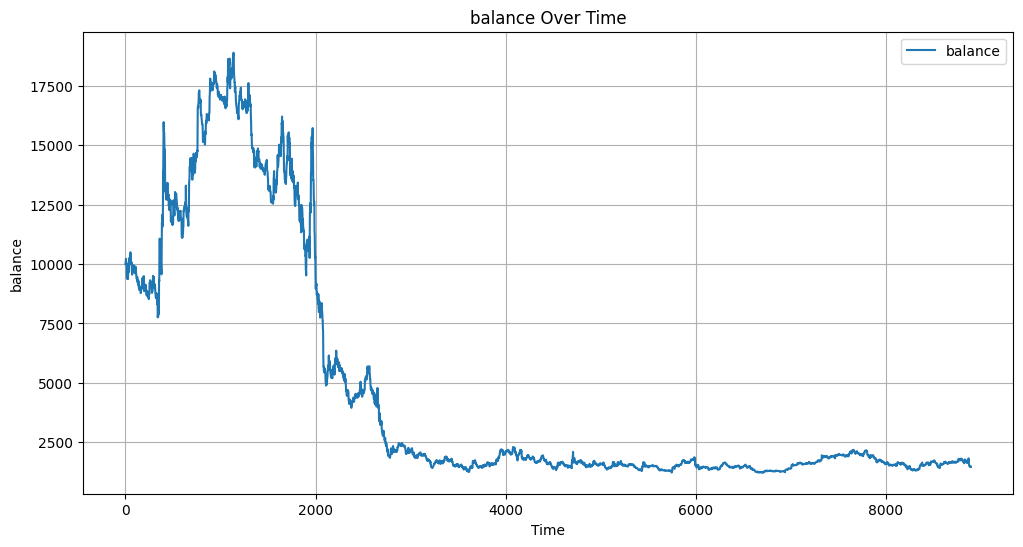

In [9]:
import matplotlib.pyplot as plt

print("\nPlotting Balance Over Time:")
plt.figure(figsize=(12, 6))
plt.plot(processed_ledger.index, processed_ledger['balance'], label='balance')
plt.xlabel('Time')
plt.ylabel('balance')
plt.title('balance Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Display unique values in 'signals' and 'action' columns
print("\nUnique Values in 'signal' Column:")
print(processed_ledger['signal'].unique())

print("\nUnique Values in 'action' Column:")
print(processed_ledger['action'].unique())


Unique Values in 'signal' Column:
['Sell' 'Buy']

Unique Values in 'action' Column:
['Short' 'Long']


In [11]:
# Check the balance after each action
print("\nBalance After Each Action:")
print(processed_ledger[['action', 'balance']])


Balance After Each Action:
     action       balance
0     Short  10000.000000
1      Long  10038.477509
2      Long  10038.477509
3     Short  10090.070251
4     Short  10090.070251
...     ...           ...
8892  Short   1479.602350
8893   Long   1488.917386
8894   Long   1488.917386
8895  Short   1465.208565
8896  Short   1465.208565

[8897 rows x 2 columns]


In [12]:
# Calculate the final balance
final_balance = processed_ledger['balance'].iloc[-1]
print(f"Final Balance: {final_balance:.2f}")

Final Balance: 1465.21


In [13]:
# Describe the DataFrame to get summary statistics
print("\nSummary Statistics of lager:")
print(processed_ledger.describe())


Summary Statistics of lager:
                           date_time     buy_price    sell_price          pnl  \
count                           8897   8897.000000   8897.000000  8897.000000   
mean   2022-04-27 14:17:40.941890560  32858.119157  16431.547045    -0.011271   
min              2020-01-01 04:00:00   4565.590000      0.000000   -15.410000   
25%              2021-02-27 04:00:00  19168.180000      0.000000    -0.070000   
50%              2022-04-27 16:00:00  29922.040000      0.000000     0.000000   
75%              2023-07-08 00:00:00  44322.420000  29922.040000     0.000000   
max              2024-08-11 20:00:00  73267.080000  73267.080000    19.880000   
std                              NaN  17600.449653  20614.033598     1.441996   

            balance  
count   8897.000000  
mean    4613.050918  
min     1219.016278  
25%     1526.844590  
50%     1738.596778  
75%     5537.906253  
max    18897.211199  
std     5108.321840  


In [14]:
# Check for any missing values in the DataFrame
print("\nMissing Values in lager:")
print(processed_ledger.isnull().sum())


Missing Values in lager:
date_time     0
signal        0
action        0
buy_price     0
sell_price    0
pnl           0
balance       0
dtype: int64


In [38]:
# Check the data types of each column
print("\nData Types of Columns in lager:")
print(processed_ledger.dtypes)



Data Types of Columns in lager:
date          datetime64[ns]
signal                object
action                object
buy_price            float64
sell_price           float64
pnl                  float64
balance              float64
dtype: object


In [15]:
processed_ledger.index.value_counts('-1')

0       0.000112
5934    0.000112
5928    0.000112
5929    0.000112
5930    0.000112
          ...   
2960    0.000112
2959    0.000112
2958    0.000112
2957    0.000112
8896    0.000112
Name: proportion, Length: 8897, dtype: float64